In [13]:
import os
import numpy as np
import matplotlib.pyplot as plt
import flopy
%matplotlib inline

In [31]:
ws = '../Model/TEST'
if not os.path.exists(ws): #make sure workspace directory exists
    os.makedirs(ws)
name = 'test'
exe_name = os.path.abspath('../bin/swtv4')

In [9]:
swt = flopy.seawat.Seawat(modelname=name, 
                          model_ws=ws, exe_name=exe_name)
print(swt.namefile)

test.nam


#### Building and post-processing a MODFLOW-2005 model

The model domain will be discretized into 3 layers, 21 rows, and 20 columns. A constant value of 500. will delr and delc. The top of the model should be set to 400 and the bottom of the three layers should be set to 220, 200, and 0. The model has one steady-state stress period.

In [11]:
nlay, nrow, ncol = 3, 21, 20
delr = delc = 500.
top = 400.
botm = [220, 200, 0]

In [12]:
dis = flopy.modflow.ModflowDis(swt, nlay=nlay, nrow=nrow, 
                               ncol=ncol, top=top, botm=botm, 
                               delr=delr, delc=delc)

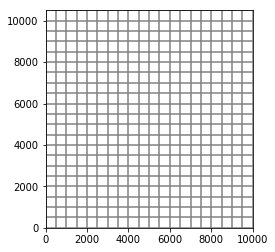

In [20]:
mm = flopy.plot.PlotMapView(model = swt)
mm.plot_grid()
#dis.plot()

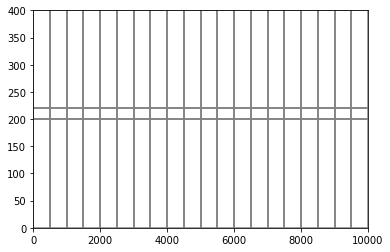

In [17]:
xs = flopy.plot.PlotCrossSection(model=swt, line={'row': 10})
xs.plot_grid()

#### Create the basic (BAS) package

Set the initial head at 320. Default values can be used for the rest of the basic package input.

In [19]:
bas = flopy.modflow.ModflowBas(swt, strt=320) 

#### Create the layer property flow (LPF) package  

The hydraulic properties for the model are defined in the image above. The first layer should be convertible (unconfined) and the remaining two layers will be non-convertible so laytyp should be [1, 0, 0].

In [21]:
kh = [50, 0.01, 200]
kv = [10, 0.01, 20]
laytyp = [1, 0, 0]

#### Create the recharge package

The recharge rate is defined in the image above.

In [22]:
rch = flopy.modflow.ModflowRch(swt, rech=0.005)

#### Create the well package

The well is located in layer 3, row 11, column 10. The pumping rate is defined in the image above.

In [23]:
wel_spd = {0: [[2, 10, 9, -150000]]}
wel = flopy.modflow.ModflowWel(swt, stress_period_data=wel_spd)

#### Create the river package

The river is located in layer 1 and column 20 in every row in the model. The river stage stage and bottom are at 320 and 318, respectively; the river conductance is 1e5.

In [25]:
riv_spd = {0: [[0, i, 19, 320, 1e5, 318] for i in range(nrow)]}
riv_spd
riv = flopy.modflow.ModflowRiv(swt, stress_period_data=riv_spd)

#### Add the PCG solver package

Set rclose to 0.1 and use default values for the PCG package variables.

In [26]:
pcg = flopy.modflow.ModflowPcg(swt, rclose=0.1)

#### Build output control

Define the output control for the model and set `stress_period_data` to `{(0, 0): ['save head', 'save budget']}` to save the head and flow for the model. Because we haven't set `ipakcb` to save flows for the packages we can use the `.reset_budgetunit()` method on the oc object to set the `ipakcb` for all packages that can save flows; set `budgetunit` to 131.

In [28]:
oc = flopy.modflow.ModflowOc(swt, stress_period_data={(0, 0): ['save head', 'save budget']})
oc.reset_budgetunit(budgetunit=131)

#### Create the basic MT3DMS and Seawatmodel structure


In [59]:
qinflow = 5.702  #m3/day
dmcoef = 0.57024 #m2/day  Could also try 1.62925 as another case of the Henry problem
hk = 864.  #m/day

# save cell fluxes to unit 53
ipakcb = 53

# Create WEL and SSM data
itype = flopy.mt3d.Mt3dSsm.itype_dict()
wel_data = {}
ssm_data = {}
wel_sp1 = wel_spd
ssm_sp1 = []
for k in range(nlay):
    #wel_sp1.append([k, 0, 0, qinflow / 3]) 
    ssm_sp1.append([k, 0, 0, 0., itype['WEL']])
    ssm_sp1.append([k, 0, ncol - 1, 35., itype['BAS6']])
wel_data[0] = wel_sp1
ssm_data[0] = ssm_sp1
wel = flopy.modflow.ModflowWel(swt, stress_period_data=wel_data, ipakcb=ipakcb)




#mt = flopy.mt3d.Mt3dms(modelname, 'nam_mt3dms', mf, model_ws=workspace)
btn = flopy.mt3d.Mt3dBtn(swt, nprs=-5, prsity=0.35, sconc=35., ifmtcn=0,
                         chkmas=False, nprobs=10, nprmas=10, dt0=0.001)
adv = flopy.mt3d.Mt3dAdv(swt, mixelm=0)
dsp = flopy.mt3d.Mt3dDsp(swt, al=0., trpt=1., trpv=1., dmcoef=dmcoef)
gcg = flopy.mt3d.Mt3dGcg(swt, iter1=500, mxiter=1, isolve=1, cclose=1e-7)
ssm = flopy.mt3d.Mt3dSsm(swt, stress_period_data=ssm_data)

#mswt = flopy.seawat.Seawat(modelname, 'nam_swt', mf, mt, model_ws=workspace, exe_name='swtv4')
vdf = flopy.seawat.SeawatVdf(swt, iwtable=0, densemin=0, densemax=0,
                             denseref=1000., denseslp=0.7143, firstdt=1e-3)

Exception: MfList error: unsupported data type: <class 'dict'> at kper 0

#### Write the model files and run the model

In [47]:
swt.write_input()
swt.run_model()

FloPy is using the following  executable to run the model: C:\Users\Chelsea\Documents\Projects\DelawareStream\FloPy\bin\swtv4.exe

                                  SEAWAT Version 4
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 4.00.05 10/19/2012                      

Incorporated MODFLOW Version: 1.18.01 06/20/2008                      
Incorporated MT3DMS  Version: 5.20    10/30/2006                      


 This program is public domain and is released on the
 condition that neither the U.S. Geological Survey nor
 the United States Government may be held liable for any
 damages resulting from their authorized or unauthorized
 use.


 Using NAME file: test.nam                                                                                                                                                                                                
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2019/06/26 16:26:12


 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:   50   Step Size:  1.0000E-03 Total Elapsed Time:  5.00000E-02
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:   51   Step Size:  1.0000E-03 Total Elapsed Time:  5.10000E-02
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:   52   Step Size:  1.0000E-03 Total Elapsed Time:  5.20000E-02
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:   53   Step Size:  1.0000E-03 Total Elapsed Time:  5.30000E-02
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:   54   Step Size:  1.0000E-03 Total Elapsed Time:  5.40000E-02
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:   55   Step Size:  1.0000E-03 Total Elapsed Time:  5.50000E-02
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  104   Step Size:  1.0000E-03 Total Elapsed Time:  0.10400    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  105   Step Size:  1.0000E-03 Total Elapsed Time:  0.10500    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  106   Step Size:  1.0000E-03 Total Elapsed Time:  0.10600    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  107   Step Size:  1.0000E-03 Total Elapsed Time:  0.10700    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  108   Step Size:  1.0000E-03 Total Elapsed Time:  0.10800    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  109   Step Size:  1.0000E-03 Total Elapsed Time:  0.10900    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  159   Step Size:  1.0000E-03 Total Elapsed Time:  0.15900    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  160   Step Size:  1.0000E-03 Total Elapsed Time:  0.16000    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  161   Step Size:  1.0000E-03 Total Elapsed Time:  0.16100    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  162   Step Size:  1.0000E-03 Total Elapsed Time:  0.16200    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  163   Step Size:  1.0000E-03 Total Elapsed Time:  0.16300    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  164   Step Size:  1.0000E-03 Total Elapsed Time:  0.16400    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  213   Step Size:  1.0000E-03 Total Elapsed Time:  0.21300    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  214   Step Size:  1.0000E-03 Total Elapsed Time:  0.21400    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  215   Step Size:  1.0000E-03 Total Elapsed Time:  0.21500    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  216   Step Size:  1.0000E-03 Total Elapsed Time:  0.21600    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  217   Step Size:  1.0000E-03 Total Elapsed Time:  0.21700    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  218   Step Size:  1.0000E-03 Total Elapsed Time:  0.21800    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  266   Step Size:  1.0000E-03 Total Elapsed Time:  0.26600    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  267   Step Size:  1.0000E-03 Total Elapsed Time:  0.26700    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  268   Step Size:  1.0000E-03 Total Elapsed Time:  0.26800    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  269   Step Size:  1.0000E-03 Total Elapsed Time:  0.26900    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  270   Step Size:  1.0000E-03 Total Elapsed Time:  0.27000    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  271   Step Size:  1.0000E-03 Total Elapsed Time:  0.27100    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  320   Step Size:  1.0000E-03 Total Elapsed Time:  0.32000    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  321   Step Size:  1.0000E-03 Total Elapsed Time:  0.32100    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  322   Step Size:  1.0000E-03 Total Elapsed Time:  0.32200    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  323   Step Size:  1.0000E-03 Total Elapsed Time:  0.32300    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  324   Step Size:  1.0000E-03 Total Elapsed Time:  0.32400    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  325   Step Size:  1.0000E-03 Total Elapsed Time:  0.32500    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Transport Step:  377   Step Size:  1.0000E-03 Total Elapsed Time:  0.37700    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  378   Step Size:  1.0000E-03 Total Elapsed Time:  0.37800    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  379   Step Size:  1.0000E-03 Total Elapsed Time:  0.37900    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  380   Step Size:  1.0000E-03 Total Elapsed Time:  0.38000    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  381   Step Size:  1.0000E-03 Total Elapsed Time:  0.38100    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  382   Step Size:  1.0000E-03 Total Elapsed Time:  0.38200    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  383   Step Size:  1.00

 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  430   Step Size:  1.0000E-03 Total Elapsed Time:  0.43000    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  431   Step Size:  1.0000E-03 Total Elapsed Time:  0.43100    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  432   Step Size:  1.0000E-03 Total Elapsed Time:  0.43200    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  433   Step Size:  1.0000E-03 Total Elapsed Time:  0.43300    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  434   Step Size:  1.0000E-03 Total Elapsed Time:  0.43400    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  435   Step Size:  1.0000E-03 Total Elapsed Time:  0.43500    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Transport Step:  486   Step Size:  1.0000E-03 Total Elapsed Time:  0.48600    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  487   Step Size:  1.0000E-03 Total Elapsed Time:  0.48700    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  488   Step Size:  1.0000E-03 Total Elapsed Time:  0.48800    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  489   Step Size:  1.0000E-03 Total Elapsed Time:  0.48900    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  490   Step Size:  1.0000E-03 Total Elapsed Time:  0.49000    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  491   Step Size:  1.0000E-03 Total Elapsed Time:  0.49100    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  492   Step Size:  1.00

 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  544   Step Size:  1.0000E-03 Total Elapsed Time:  0.54400    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  545   Step Size:  1.0000E-03 Total Elapsed Time:  0.54500    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  546   Step Size:  1.0000E-03 Total Elapsed Time:  0.54600    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  547   Step Size:  1.0000E-03 Total Elapsed Time:  0.54700    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  548   Step Size:  1.0000E-03 Total Elapsed Time:  0.54800    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  549   Step Size:  1.0000E-03 Total Elapsed Time:  0.54900    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Transport Step:  597   Step Size:  1.0000E-03 Total Elapsed Time:  0.59700    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  598   Step Size:  1.0000E-03 Total Elapsed Time:  0.59800    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  599   Step Size:  1.0000E-03 Total Elapsed Time:  0.59900    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  600   Step Size:  1.0000E-03 Total Elapsed Time:  0.60000    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  601   Step Size:  1.0000E-03 Total Elapsed Time:  0.60100    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  602   Step Size:  1.0000E-03 Total Elapsed Time:  0.60200    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  603   Step Size:  1.00

 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  655   Step Size:  1.0000E-03 Total Elapsed Time:  0.65500    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  656   Step Size:  1.0000E-03 Total Elapsed Time:  0.65600    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  657   Step Size:  1.0000E-03 Total Elapsed Time:  0.65700    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  658   Step Size:  1.0000E-03 Total Elapsed Time:  0.65800    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  659   Step Size:  1.0000E-03 Total Elapsed Time:  0.65900    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  660   Step Size:  1.0000E-03 Total Elapsed Time:  0.66000    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  712   Step Size:  1.0000E-03 Total Elapsed Time:  0.71200    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  713   Step Size:  1.0000E-03 Total Elapsed Time:  0.71300    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  714   Step Size:  1.0000E-03 Total Elapsed Time:  0.71400    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  715   Step Size:  1.0000E-03 Total Elapsed Time:  0.71500    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  716   Step Size:  1.0000E-03 Total Elapsed Time:  0.71600    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  717   Step Size:  1.0000E-03 Total Elapsed Time:  0.71700    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  771   Step Size:  1.0000E-03 Total Elapsed Time:  0.77100    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  772   Step Size:  1.0000E-03 Total Elapsed Time:  0.77200    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  773   Step Size:  1.0000E-03 Total Elapsed Time:  0.77300    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  774   Step Size:  1.0000E-03 Total Elapsed Time:  0.77400    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  775   Step Size:  1.0000E-03 Total Elapsed Time:  0.77500    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  776   Step Size:  1.0000E-03 Total Elapsed Time:  0.77600    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  826   Step Size:  1.0000E-03 Total Elapsed Time:  0.82600    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  827   Step Size:  1.0000E-03 Total Elapsed Time:  0.82700    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  828   Step Size:  1.0000E-03 Total Elapsed Time:  0.82800    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  829   Step Size:  1.0000E-03 Total Elapsed Time:  0.82900    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  830   Step Size:  1.0000E-03 Total Elapsed Time:  0.83000    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  831   Step Size:  1.0000E-03 Total Elapsed Time:  0.83100    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  882   Step Size:  1.0000E-03 Total Elapsed Time:  0.88200    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  883   Step Size:  1.0000E-03 Total Elapsed Time:  0.88300    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  884   Step Size:  1.0000E-03 Total Elapsed Time:  0.88400    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  885   Step Size:  1.0000E-03 Total Elapsed Time:  0.88500    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  886   Step Size:  1.0000E-03 Total Elapsed Time:  0.88600    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  887   Step Size:  1.0000E-03 Total Elapsed Time:  0.88700    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Transport Step:  936   Step Size:  1.0000E-03 Total Elapsed Time:  0.93600    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  937   Step Size:  1.0000E-03 Total Elapsed Time:  0.93700    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  938   Step Size:  1.0000E-03 Total Elapsed Time:  0.93800    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  939   Step Size:  1.0000E-03 Total Elapsed Time:  0.93900    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  940   Step Size:  1.0000E-03 Total Elapsed Time:  0.94000    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  941   Step Size:  1.0000E-03 Total Elapsed Time:  0.94100    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  942   Step Size:  1.00

 Transport Step:  988   Step Size:  1.0000E-03 Total Elapsed Time:  0.98800    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  989   Step Size:  1.0000E-03 Total Elapsed Time:  0.98900    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  990   Step Size:  1.0000E-03 Total Elapsed Time:  0.99000    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  991   Step Size:  1.0000E-03 Total Elapsed Time:  0.99100    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  992   Step Size:  1.0000E-03 Total Elapsed Time:  0.99200    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  993   Step Size:  1.0000E-03 Total Elapsed Time:  0.99300    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  994   Step Size:  1.00

(True, [])

#### Try to delete the output files, to prevent accidental use of older files

In [53]:
try:
    os.remove(os.path.join(ws, 'MT3D001.UCN'))
    os.remove(os.path.join(ws, name + '.hds'))
    os.remove(os.path.join(ws, name + '.cbc'))
except:
    pass

In [ ]:
v = swt.run_model(silent=True, report=True)
for idx in range(-3, 0):
    print(v[1][idx])

#### Post-process the results

Load the heads and face flows from the hds and cbc files. The head file can be loaded with the `flopy.utils.HeadFile()` method. The cell-by-cell file can be loaded with the `flopy.utils.CellBudgetFile()` method. The entries in the cell-by-cell file can be determined with the `.list_unique_records()` method on the cell budget file object.

In [58]:
# Post-process the results
import flopy.utils.binaryfile as bf

# Load data
ucnobj = bf.UcnFile(os.path.join(ws, 'MT3D001.UCN'), model=swt)
times = ucnobj.get_times()
concentration = ucnobj.get_data(totim=times[-1])
cbbobj = bf.CellBudgetFile(os.path.join(ws, 'test.cbc'))
times = cbbobj.get_times()
qx = cbbobj.get_data(text='flow right face', totim=times[-1])[0]
qz = cbbobj.get_data(text='flow lower face', totim=times[-1])[0]

# Average flows to cell centers
qx_avg = np.empty(qx.shape, dtype=qx.dtype)
qx_avg[:, :, 1:] = 0.5 * (qx[:, :, 0:ncol-1] + qx[:, :, 1:ncol])
qx_avg[:, :, 0] = 0.5 * qx[:, :, 0]
qz_avg = np.empty(qz.shape, dtype=qz.dtype)
qz_avg[1:, :, :] = 0.5 * (qz[0:nlay-1, :, :] + qz[1:nlay, :, :])
qz_avg[0, :, :] = 0.5 * qz[0, :, :]

Exception: The specified text string is not in the budget file.

In [ ]:
fpth = os.path.join(ws, name+'.hds')
hobj = flopy.utils.HeadFile(fpth)
hds = hobj.get_data()
fpth = os.path.join(ws, name+'.cbc')
cobj = flopy.utils.CellBudgetFile(fpth)
cobj.list_unique_records()

Retrieve the `'FLOW RIGHT FACE'` and `'FLOW FRONT FACE'` data types from the cell-by-cell file.

In [49]:
frf = cobj.get_data(text='FLOW RIGHT FACE')[0]
fff = cobj.get_data(text='FLOW FRONT FACE')[0]

Exception: The specified text string is not in the budget file.

#### Plot the results

Plot the results using flopy.plot.PlotMapView(). The head results can be plotted using the .plot_array() method. The discharge results can be plotted using the plot_discharge() method. Boundary conditions can be plotted using the .plot_bc() method.

NameError: name 'mv' is not defined

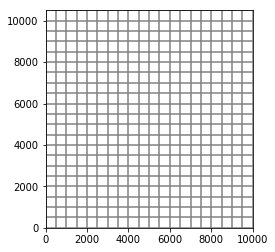

In [50]:
mm = flopy.plot.PlotMapView(model=swt, layer=0)
mm.plot_grid()
mv.plot_array(hds, cmap='jet') #plot simulated heads
mm.plot_array(hds)
mm.plot_discharge(frf=frf, fff=fff)
mm.plot_bc('RIV')
mm.plot_bc('WEL')